# Homework 4 
Pedro Augusto Januzzi Guerra

# Questions

1. Use the finite element method to solve the problem in HW2 with constraints that may bind:

\begin{align*}
    \max_{c_t,k_{t+1}} &\mathbb{E}\sum_{t=0}^\infty \beta^t \frac{c_y^{1-\theta}-1}{1-\sigma}\\
    \text{s.t.}\hspace{3mm}& c_t+k_{t+1} - (1-\delta)k_t = z_tk_t^\alpha\\
    & \log z_t = \rho \log z_{t-1} + \epsilon_t,\hspace{3mm}\epsilon_t \sim N(0,\sigma_\epsilon^2)\\
    & c_t \leq z_tk_t^\alpha
\end{align*}

2. (Optional) Use the finite element method to solve the problem in HW3 with the same inequality constraints above.

---
I had three main sources for preparing this file. First, I used Chapter 6, written by Ellen McGrattan, from the book Computational Methods for the Study of Dynamic Economies, henceforth referred to as Marimon and Scott (1999). The second source was Ellen's paper, Solving the Stochastic Growth Model with a Finite Element Method, which I refer to as McGrattan (1994). During my master’s, I took a course on Numerical Methods where we studied Projection Methods. Hence, as a guide for this homework, I also used the set of slides prepared by Professor Cezar Santos. Lastly, I used the book "Numerical Methods in Economics", written by Judd, to get the expression for the Gauss-Chebyshev quadrature.

In McGrattan (1994), a stochastic growth model similar to ours is solved. At first, Ellen doesn't include a constraint on positive investment (which in our model is equivalent to having $c_t \leq z_tk_t^\alpha$). Later, Ellen includes the mentioned constraint. In order to fix and understand well the concepts, I will follow the paper and start with a simpler problem, in which there is no non-negativity constraint over investment. 

Moreover, note that the process for TFP shocks in our homework is given by $$\log z_t = \rho\log z_{t-1} + \epsilon_t,\hspace{4mm}\epsilon\sim N(0,\sigma_\epsilon^2)$$

As highlighted in McGrattan (1994), there are two ways to deal with the shocks. The first one is a Markov chain with transition probabilities $$\Pi_{i,j} = \text{Pr}[z_t = z(j) | z_{t-1} = z(i)], \hspace{4mm} 1\leq i,j\leq I$$ in which $I$ represent the cardinality of the shocks' space.

The second specification is the continuous=valued autoregressive process. 

I decided to proceed with the first option, as I'm more familiar with it and, at least at this point, it helps me to visualize the transition probabilities displayed in a matrix. 

Since an AR(1) is a continous process, in order to compute the Markov chain, it's necessary to discretize the continuous process. I know two ways to accomplish this task: the Tauchen's method and the Rouwenhorst method. As far as I know, the Tauchen's method might not be the best choice when the persistence of the AR(1) is close to 1. Since I have worked with $\rho = 0.95$ in Homework 3 and I'll use the same parameters' values here, the Tauchen's method is reliable and I'll use it to discretize the continuous process.

First, let's understand what is the Tauchen's method. Consider a more general AR(1) process $$\theta_t = (1-\rho)\mu + \rho\theta_{t-1} + \varepsilon_t, \hspace{4mm} \varepsilon\sim N(0,\sigma^2)$$

Our goal is to discretize $\theta$ so that the resulting process is a good approximation for the continuous AR(1) process. The first task is to determine the range of the grid and number of grid points, $N$, in our shocks' space. Following the method, set the upper bound of the grid, $\theta_N$, to be $$\theta_N = \frac{m\sigma}{\sqrt(1-\rho^2)}$$ where $m$ is a scaling parameter. 

The lower bound, $\theta_1$ is to be equal to $-\theta_N$. The remaining $N-2$ grid points are equidistantly distributed between the lower and upper bounds.

The next step is to compute the probability of moving to state $\theta_j$ given that your current state is $\theta_i$. Let $p_{i,j}$ denote this probability. Then, $p_{i,j}$ is given by:

$$p_{i,j} = \text{Prob}\Bigg(\theta_j - \frac{\Delta\theta}{2} \leq (1-\rho)\mu+\rho\theta_i+\varepsilon' \leq \theta_j + \frac{\Delta\theta}{2}\Bigg)$$

Rearranging the expression above yields:

$$p_{i,j} = \text{Prob}\Bigg(\theta_j - \frac{\Delta\theta}{2} - (1-\rho)\mu-\rho\theta_i\leq \varepsilon' \leq \theta_j + \frac{\Delta\theta}{2}- (1-\rho)\mu-\rho\theta_i\Bigg)$$

where $\Delta\theta = (\theta_N-\theta_1)(N-1)^{-1}$ represents the width between two grid points.

Lastly, let $F$ denote the cumulative density of the standard normal distribution. The expression above can be rewritten as:

$$p_{i,j} = F\Bigg(\frac{(\theta_j + \frac{\Delta\theta}{2} - (1-\rho)\mu-\rho\theta_i}{\sigma}\Bigg) - F\Bigg(\frac{(\theta_j - \frac{\Delta\theta}{2} - (1-\rho)\mu-\rho\theta_i}{\sigma}\Bigg)$$

and the transition for the corners are given by:

$$p_{i,1} = F\Bigg(\frac{\theta_1 + \frac{\Delta\theta}{2} - (1-\rho)\mu-\rho\theta_i}{\sigma}\Bigg)$$

$$p_{i,N} = 1- F\Bigg(\frac{\theta_N - \frac{\Delta\theta}{2} - (1-\rho)\mu-\rho\theta_i}{\sigma}\Bigg)$$

Now, let's start working on question 1.

---
# Question 1

In [24]:
# Packages used
using LinearAlgebra, Plots, Distributions, PrettyTables, NLsolve

Create a function to discretize the TFP's continuous process using Tauchen:

In [25]:
# Function to discretize the process of shocks via Tauchen

function Tauchen(rho, sigma, mu, scale, number_pts)
    upper_bound = scale * sigma / sqrt(1 - rho^2)
    lower_bound = -upper_bound
    grid_z = LinRange(lower_bound, upper_bound, number_pts)

    delta_z = (upper_bound - lower_bound) / (number_pts - 1)

    P = zeros(number_pts, number_pts)

    dist = Normal(mu, sigma)

    for i = 1:number_pts
        P[i,1] = cdf(dist, (grid_z[1] - (1 - rho) * mu .- rho * grid_z[i] + delta_z / 2))
        P[i, end] = 1 - cdf(dist, (grid_z[end] - (1 - rho) * mu - rho * grid_z[i] - delta_z / 2))

        for j = 2:(number_pts-1)
            P[i,j] = cdf(dist, (grid_z[j] + delta_z / 2 - (1 - rho) * mu - rho * grid_z[i])) -
                        cdf(dist, (grid_z[j] - delta_z / 2 - (1 - rho) * mu - rho * grid_z[i]))
        end
    end
    
    return P, grid_z
end

Tauchen (generic function with 1 method)

Set parameters' values:

In [26]:
# Parameters (chosen by me and consistent with the choices made in HW 2)
β = 0.95; # discount factor
δ = 0.05; # depreciation rate
α = 0.33; # output elasticity of capital
ρ = 0.95; # persistence of shocks
σ_ϵ = 0.01; #st.dev. of error term in the shock's process
σ = 2; # relative risk aversion coefficient
m = 3; # scaling parameter
N = 7; # number of grid points
μ = 0; # mean of AR(1) process

Calculate grid for shocks:

In [27]:
# T is the transition matrix (Markov chain) and z_grid the grid for shocks
T,z_grid = Tauchen(ρ, σ_ϵ, μ, m, N);

Note that, in the explation on the Tauchen's method, I considered an AR(1) process in levels, but our TFP process is in logs, so I have to take the exponential of the grid of shocks.

In [28]:
z_grid = exp.(z_grid);

Build tables with the grid for shocks and Markov chain:

In [29]:
# Setting a table 
pretty_table(round.(z_grid';digits=4); header = ["$i" for i = 1:N],
            title = "Grid of shocks",
            border_crayon = crayon"bold yellow",
            tf = tf_simple)

println("-"^70)  # separator = 70 dashes

pretty_table(round.(T;digits=4); header = ["$i" for i = 1:N],
            title = "Transition Matrix via Tauchen's Method",
            row_labels = ["$x" for x = 1:N],
            border_crayon = crayon"bold yellow",
            tf = tf_simple)

Grid of shocks
========= ======= ======== ===== ======== ======== =========
       1       2        3     4        5        6        7  
========= ======= ======== ===== ======== ======== =========
  0.9084   0.938   0.9685   1.0   1.0325   1.0661   1.1008  
========= ======= ======== ===== ======== ======== =========
----------------------------------------------------------------------
Transition Matrix via Tauchen's Method
==== ======== ======== ======== ======== ======== ======== =========
           1        2        3        4        5        6        7  
==== ======== ======== ======== ======== ======== ======== =========
  1   0.8688   0.1312      0.0      0.0      0.0      0.0      0.0  
  2   0.0273   0.8726   0.1001      0.0      0.0      0.0      0.0  
  3      0.0   0.0391   0.8861   0.0748      0.0      0.0      0.0  
  4      0.0      0.0   0.0547   0.8907   0.0547      0.0      0.0  
  5      0.0      0.0      0.0   0.0748   0.8861   0.0391      0.0  
  6      0.0      

Now, let's proceed to the Galerkin method. First, we will provide a brief explanation of what it is, based on the sources used. I will begin by including some helpful sentences from Marimon and Scott (1999) that clearly explain the key concepts we will use to solve the homework.

From Marimon and Scott (1999):

"Many problems in economics require the solution to a functional equation as an intermediate
step. Typically, we seek decision functions that satisfy a set of Euler conditions
or a value function that satisfies Bellman's equation. In many cases, we cannot derive
analytical solutions for these functions and instead must rely on numerical methods. In
this chapter, I will show how to apply weighted residual and finite-element methods to
this type of problem.

(...)

The finite-element method can be viewed as a piecewise application of the weighted
residual method. With the finite-element method, the first step in solving the functional
equation is to subdivide the domain of the state space into non-intersecting subdomains
called elements. The domain is subdivided because the method relies on fitting low-order
polynomials on subdomains of the state space rather than high-order polynomials on the
entire state space. The local approximations are then pieced together to give a global
approximation. As the dimensionality of the problem increases, higher-order functions
can be used where needed, with fewer elements."

"The general procedure:

The problem is to find $d: \mathbb{R}^m \rightarrow \mathbb{R}^n$ that satisfies a functional equation $F(d) = 0$,
where $F: C_1\rightarrow C_2$ and $C_1$ and $C_2$ are function spaces. As an example, I can think
of $d$ as decision or policy variables and $F$ as first-order conditions from some maximization
problem. My goal here is to find an approximation $d^n(x; \theta)$ on $x \in \Omega$ which
depends on a finite-dimensional vector of parameters $\theta = [\theta_1, \theta_2,...,\theta_n]'$. Weighted
residual methods assume that d" is a finite linear combination of known functions, $\psi_i(x)$,
$i=0,1,...,n$, called basis functions: $$d^n(x;\theta) = \psi_0(x)+\sum_{i=1}^n\theta_i\psi_i(x)$$ The functions $\psi_i(x)$, $i=0,...,n$ are typically simple functions.

(...)

In Fig. 6.2, I display basis functions that can be used to construct a piecewise linear representation for $d^n$. These basis functions are of the form

$$    
\psi_i(x) = 
\begin{cases} 
\frac{x - x_{i-1}}{x_i - x_{i-1}} & \text{if } x \in [x_{i-1}, x_i] \\ 
\frac{x_{i+1} - x}{x_{i+1} - x_i} & \text{if } x \in [x_i, x_{i+1}] \\ 
0 & \text{elsewhere}
\end{cases}
$$

I do not need to have the points$x_i$, $i = 1,...,n$, equally spaced. Therefore, if I want
to represent a function that has large gradients or kinks in certain places - say, because
inequality constraints bind - then I can cluster points in those regions. In regions where
the function is near-linear, I do not need many points.

I define the residual equation as the functional equation evaluated at the approximate solution $d^n$: $$R(x,\theta) = F(d^n(x;\theta))$$ I want to choose $\theta$ so that $R(x;\theta)$ is close to zero for all $x$. Weighted residual methods get the residual close to zero in the weighted integral sense. That is, I choose $\theta$ so that $$\int_\Omega \phi_i(x)R(x;\theta)dx=0,\hspace{4mm}i=1,...,n$$ where $\phi_i(x)$,$i=1,...,n$, are weight functions. Note that $\phi_i(x)$ and $\psi_i(x)$ can be different functions. Alternatively, the weighted integral can be written $$\int_\Omega w(x)R(x;\theta)dx=0$$ where $w(x) = \sum_i \omega_i\phi_i(x)$.

(...)

I consider three specific sets of weight functions and, hence, three ways of determining the coefficients $\theta_1,...,\theta_n$.

(...)

1. Least squares: (...)
2. Collocation: (...)
3. Galerkin: $\phi_i(x) = \psi_i(x)$. (...)"


Some extra comments made by me:

There are several basis functions we could use. In the lecture, we saw an example (which can also be found in the book) using polynomials. In fact, there are several types of polynomials that could serve as basis functions. However, these basis functions are global, meaning they are non-zero everywhere. When we use local basis functions, which are zero over most of the domain, we employ the Finite Element Method.

Why use finite elements? If we are working with problems where the solution has a kink (for example), trying to approximate the solution with a single large polynomial may not be effective. A smarter approach is to use a piecewise function to fit the solution. In summary, finite element methods allow us to partition the state space into separate elements and use local basis functions to approximate the solution within each element.

Moving to the solution of our homework, the basis function I will use is: 

$$    
\psi_i(k) = 
\begin{cases} 
\frac{k - k_{i-1}}{k_i - k_{i-1}} & \text{if } k \in [k_{i-1}, k_i] \\ 
\frac{k_{i+1} - k}{k_{i+1} - k_i} & \text{if } k \in [k_i, k_{i+1}] \\ 
0 & \text{elsewhere}
\end{cases}
$$

Let $c$ be the approximate solution to our problem. Then, we'll have:

$$c(k;a) = \sum_{i=1}^n a_i\psi_i(k)$$

where $a_i$, $i=1,...,n$, are constants.

Our residual function (for the deterministic case) is defined by:

$$R(k;a) = u'(c(k;a))-\beta u'(c(\tilde{k};a))(1+\alpha \tilde{k}^{'^{\alpha-1}}-\delta)$$ 

where $\tilde{k}' = -c(k;a) + k^\alpha + (1-\delta)k$.

For the stochastic case, it will be analogous, but we will have an expectation over $z$ in the RHS.

Note that here I'm using a different notation from the book, so just to reconcile the notation, my $a$ corresponds to $\theta$ in the book.

The Galerkin method chooses $a$ so that $$\int_{k_1}^{k_n} R(k;a)\psi_i(k)\omega(k)dk=0\hspace{3mm}\forall i$$ in which $\omega$ is some weighting function.

Since we are dealing with finite elements, the basis function will be zero over most of the domain. Therefore, the expression above simplifies to: 

 $$\int_{[k_{i-1},k_i] \cup [k_{i},k_{i+1}]} R(k;a)\psi_i(k)\omega(k)dk=0\hspace{3mm}\forall i$$

 For simplicity, I set $\omega = 1$. Substituting $\psi_i$ and rearranging, we can define: 

 \begin{align*}
    \overline{E}_i(a) &= \int_{[k_{i},k_{i+1})} R(k;a)\frac{k_{i+1}-k}{k_{i+1}-k_i}dk \\[15pt]
    \underline{E}_i(a) &= \int_{[k_{i-1},k_{i})} R(k;a)\frac{k-k_{i-1}}{k_i-k_{i-1}}dk 
 \end{align*}

 This system of equations can be expressed as: 

$$
E(a) := 
\begin{bmatrix}
\overline{E}_1(a) \\
\underline{E}_2(a) + \overline{E}_2(a) \\
\vdots \\
\underline{E}_{n-1}(a) + \overline{E}_{n-1}(a) \\
\underline{E}_n(a) 
\end{bmatrix}
=
\begin{bmatrix}
0 \\
0 \\
\vdots \\
0 
\end{bmatrix}
$$

So our task is to find the $a$'s that solve the system above. This might sound simples, but calculating the integrals it not super simple. To this goal, I will use the Gauss-Chebyshev's quadrature, whose formula I found in page 260 of Judd (1998) and is given by:

$$
\int_a^b f(y) dy = \frac{\pi(b-a)}{2n}\sum_{i=1}^nf\Bigg(\frac{(x_i+1)(b-a)}{2}+a\Bigg)(1-x_i^2)^{1/2}
$$

where $x_i$ are the Gauss-Chebyshev quadrature nodes over $[-1,1]$.

To solve the question, let's create some useful functions:

In [30]:
# Basis function::: construction very similar to the explanation above
function psi(i,k,grid_k,n)
    if i == 1
        if k >= grid_k[i] && grid_k[i+1] >= k
            ψ = (grid_k[i+1] - k)/(grid_k[i+1] - grid_k[i]);
        else        
            ψ = 0;
        end
        
    elseif i == n   
        if k >= grid_k[i-1] && grid_k[i] >= k    
            ψ = (k - grid_k[i-1])/(grid_k[i] - grid_k[i-1]);
        else        
            ψ = 0;        
        end
        
    else        
        if k >= grid_k[i-1] && grid_k[i] >= k            
            ψ = (k - grid_k[i-1])/(grid_k[i] - grid_k[i-1]);            
        elseif k > grid_k[i] && grid_k[i+1] >= k
            ψ = (grid_k[i+1] - k)/(grid_k[i+1] - grid_k[i]);           
        else 
            ψ = 0;           
        end        
    end

    return ψ
end

# Function to compute the consumption::: construction very similar to the explanation above
function consumption(a,k,grid_k,n)
   c = 0;
   for i = 1:n
        c = c + a[i]*psi(i,k,grid_k,n) 
   end

   return c
end

# Function to compute the residuals
function residual(a,k,grid_z,j,n,α,δ,N,grid_k,σ,β,T)
    c_old = consumption(a[j,:],k,grid_k,n);
    g = grid_z[j]*(k^α)+(1-δ)*k - c_old; # policy function for capital
    aux1 = zeros(N,1);
    aux2 = zeros(N,1);

    for i=1:N
        aux1[i] = 1-δ+α*grid_z[i]*g^(α-1);
        pol_c = consumption(a[i,:],g,grid_k,n); # policy for c
        aux2[i] = (pol_c/c_old)^(-σ);
    end

    res = β.*T[j,:]'*(aux1.*aux2).-1; 
    # this yields a matrix 1x1. When I get the j-th row of T, Julia re-reads it as a column vector.

    res = res[1,1]; # transforming a matrix 1x1 into a float64

    return res
end

# Function to compute the system of residuals using the Gauss-Chebyshev quadrature
function system(int,a,grid_z,n,α,δ,N,grid_k,σ,β,T)
    residual_matrix = ones(int,N); # int is the number of quadrature points

    # Get Gauss-Chebyshev nodes over [-1,1]
    d = int-1;
    dim = d+1;
    ub_k = maximum(grid_k); #ub = upper bound
    lb_k = minimum(grid_k); #lb = lower bound

    nodes = zeros(1,dim);
    for id = 1:dim 
        nodes[id] = -cos(((2*id - 1)*π)/(2*dim));
    end

    e1 = zeros(int,N); # I should have called this e_left 
    e2 = zeros(int,N); # and this e_right
    # the sum of e1 and e2 (e_left+e_right) give me the system explained above, which has to equal zero (optimum).

    for i = 1:N 
        for j = 1:d 
            k_aux = (nodes[j]+1)*((grid_k[j+1]-grid_k[j])/2) + grid_k[j];
            aux_1 = residual(a,k_aux,grid_z,i,n,α,δ,N,grid_k,σ,β,T);
            aux_2 = sqrt(1-nodes[j]^2)*(grid_k[j+1]-k_aux)/(grid_k[j+1]-grid_k[j]);
            e1[j,i] = ((π*(grid_k[j+1] - grid_k[j]))/(2*d))*aux_1*aux_2; 
        end
    end

    for i= 1:N 
        for j = 2:int 
            k_aux = (nodes[j]+1)*((grid_k[j]-grid_k[j-1])/2) + grid_k[j-1];
            aux_1 = residual(a,k_aux,grid_z,i,n,α,δ,N,grid_k,σ,β,T);
            aux_2 = sqrt(1-nodes[j]^2)*(k_aux-grid_k[j-1])/(grid_k[j]-grid_k[j-1]);
            e2[j,i] = ((π*(grid_k[j] - grid_k[j-1]))/(2*d))*aux_1*aux_2;
        end
    end

    residual_matrix = e1 + e2;
    final_system = vec(residual_matrix); # stack in a vector

    return final_system

end

system (generic function with 1 method)

Note that this problem is essentially the one we solved in Homework 2, which means that the steady state here will be the same as in there. I will create a grid for capital around the steady state level for capital in the deterministic economy.

In [31]:
k_ss = ( (1/α) *( (1/β) - 1 + δ) )^(1/(α-1)); # steady state capital (deterministic case)
lb = 0.5*k_ss; # lower bound for the grid around 30% below the SS level
ub = 2.7*k_ss; # lower bound for the grid around 30% above the SS level
nk = 500; # number of grid points
k_grid = LinRange(lb,ub,nk); # create a linearly spaced grid for capital

Create a grid for capital for the Galerkin method and the number of intervals for the integral:

In [32]:
n = 15; # number of points (chosen by me)
k_grid_gal = LinRange(lb,ub,n); 
int = n; # quadrature points

Define an initial guess for $a$:

In [33]:
a = ones(N,n);

for i = 1:N 
    a[i,:] = LinRange(1,2,n); 
end

Note that my initial guess is very specific. This is because root-finding methods are highly sensitive to the initial guess. Without a good guess, there is no guarantee the system will converge to a reasonable approximation. However, I ran the code from HW 2 with the same parameters considered here and observed that consumption ranged between 1.2 and 1.8, which justifies the guess above.

Now, what if I were dealing with a new problem for which I have no prior information? One possible approach is to solve a simplified version of the model—perhaps without shocks or using a coarser capital grid—to get an idea of the consumption range. This would allow me to come up with a more informed initial guess.

Create a function to compute the solution of the system of residuals:

In [34]:
root_solution = x -> system(int,x,z_grid,n,α,δ,N,k_grid_gal,σ,β,T);

Solve the system using initial guess $a$:

In [35]:
solution = nlsolve(root_solution,a);

# Extract the roots:
a_opt = solution.zero;

Let's compute the policy function for consumption:

In [36]:
c_pol = zeros(N,nk);

for j=1:N 
    for i=1:nk
        c_pol[j,i] = consumption(a_opt[j,:],k_grid[i],k_grid_gal,int)
    end
end

c_pol = c_pol';

Plot the policy function for consumption:

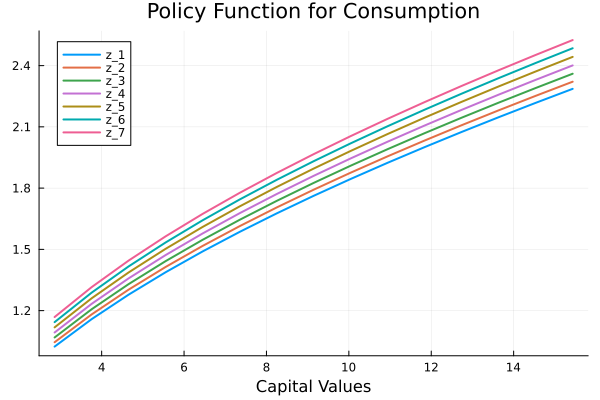

In [37]:
plot(k_grid, c_pol, label=["z_1" "z_2" "z_3" "z_4" "z_5" "z_6" "z_7"] ,title="Policy Function for Consumption"
, xlabel="Capital Values",linewidth=2)

Compute policy function for capital:

In [38]:
# Just for practicing, I'll calculate it without using loops
z_matrix = repeat(z_grid, 1, nk); # Creating a matrix by repeating grid_z to become 500x7
k_matrix = repeat(k_grid, 1, N)';  # Creating a matrix by repeating grid_k to become 7x500 and then transposing it

k_pol = z_matrix.*(k_matrix.^α)+(1-δ).*k_matrix-c_pol';

k_pol = k_pol';

Plot the policy function for capital:

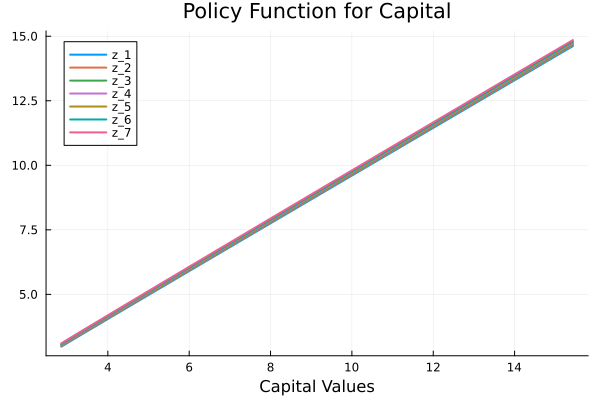

In [39]:
plot(k_grid, k_pol, label=["z_1" "z_2" "z_3" "z_4" "z_5" "z_6" "z_7"] ,title="Policy Function for Capital"
, xlabel="Capital Values",linewidth=2)

Compute investment using feasibility. Recall that here there is no non-negativity constraint over investment.

In [40]:
x_pol = zeros(N,nk);

for j=1:N
    for i=1:nk
        x_pol[j,i] = z_grid[j]*k_grid[i]^α - c_pol[i,j];
    end
end

x_pol = x_pol';

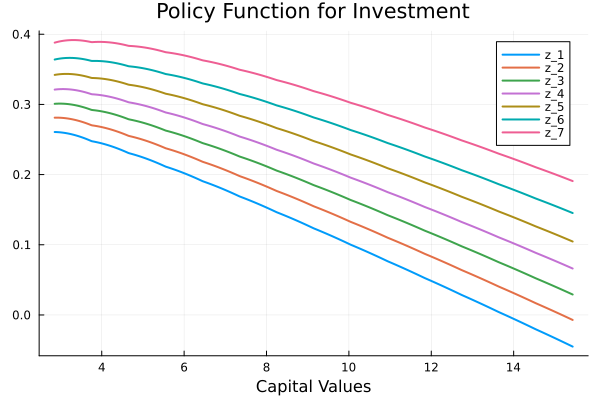

In [41]:
plot(k_grid, x_pol, label=["z_1" "z_2" "z_3" "z_4" "z_5" "z_6" "z_7"] ,title="Policy Function for Investment"
, xlabel="Capital Values",linewidth=2)

Now, let's impose a non-negativity constraint on investment. That is, $x_t\geq 0 \hspace{2mm}\forall t$. From the feasibility constraint, it follows that $$c_t\leq z_tk_t^\alpha\hspace{2mm}\forall t$$

Follwing McGrattan(1994), the problem can be modified so that the objective function, previously given by $$\mathbb{E}\Bigg[\sum_{t=0}^\infty \beta^t \frac{c_t^{1-\sigma}-1}{1-\sigma}| k_{-1}\Bigg],\hspace{4mm}\beta\in (0,1),\hspace{2mm}\sigma>0$$

is represented by $$\mathbb{E}\Bigg[\sum_{t=0}^\infty \beta^t\Bigg\{\frac{c_t^{1-\sigma}-1}{1-\sigma} + \frac{1}{3}\gamma\min (z_tk_{t}^\alpha-c_t,0)^3\Bigg\}\Bigg],\hspace{4mm}\beta\in (0,1),\hspace{2mm}\sigma>0$$

From McGrattan(1994):

"Notice that I have included a penalty function of the form $min(x,0)^3$ which is equal to $0$ for values of $x$ greater than $0$ and $x^3$ for negative values of $x$ (for more details on penalty functions, see Fletcher, 1987). If the constraint is violated and investment is negative, then there is a loss in utility. The larger is consumption relative to income, the larger is the penalty. 

The size of the penalty is determined by the value of the parameter $\gamma$. To compute the optimal decision function, I solve a sequence of optimization problems, each indexed by a different penalty parameter. One approach is to choose a sequence of $\gamma^{(j)}$, such as $\{1,10,10^2,10^3,...\}$, which has $\gamma^{(j)}\rightarrow\infty$; the finite element approximation is calculated for each $\gamma^{(j)}$ until the constraints are approximately satisfied. If too many approximations need to be calculated, then this method is inefficient. Also, the numerical optimization of the equation above becomes increasingly difficult as $\gamma^{(j)}$ approaches infinity. A shortcut method often used in practice is to pick only one or two largish values for $\gamma$."

The strategy I adopt here is slightly different and was an easier way I found to impose a non-negativity constraint on investment. I'm not sure whether it's completely correct, but after considering it, it seems that, in the end, it's similar to using penalty functions. By including such a function, we are essentially forcing consumption not to exceed a certain cutoff ($z_tk_t^\alpha$), which is essentially what I do, though in a less natural way.

Update on this last note: I asked Ellen and she said this could work in some problems, but not in all. The idea is that the constraint could affect the agent's decisions and so the "moment" at which investment becomes zero when we use penalty functions might be different than the "moment" when I just impose that, whenever the optimal policy implies a negative investment, this agent is limited by the constraint (which is essentially what I do). 

When we include the penalty functions, the FOCs with respect to consumption and savings are: 

\begin{align*}
[c_t]:&\hspace{3mm} \beta^t c_t^{-\sigma} -\beta^t\gamma\min(zk_t^\alpha - c_t,0)^2 = \lambda_t \\[4pt]
[k_{t+1}]:&\hspace{3mm} \lambda_t = \lambda_{t+1}[\alpha zk_t^{\alpha-1} + 1-\delta] + \mathbb{E}[\beta^{t+1}\gamma\min(z k_{t+1}^\alpha - c_{t+1},0)^2](z k_{t+1}^{\alpha -1}\alpha)
\end{align*}

Manipulating these expressions yield the following Euler Equation: $$c_t^{-\sigma}\gamma\min(z k_t^\alpha-c_t,0)^2 = \beta \mathbb{E}[c_{t+1}^{-\sigma}(\alpha z k_{t+1}^{\alpha-1} + 1-\delta)+\gamma\min(z k_{t+1}^\alpha-c_{t+1},0)^2(1-\delta)$$

---
### Using penalty function:
Update some functions:

In [42]:

# Function to compute the consumption::: construction very similar to the explanation above
function consumption_new(a,k,grid_k,n,z,α)
    c = 0;
    for i = 1:n
         c = c + a[i]*psi(i,k,grid_k,n) 
    end
    
    # Maximum allowed consumption (non-negative investment constraint)
    c_max = z*k^α;
 
    # Enforce the constraint::: the intuition of the penalty function is to do the same, but in a more natural way, penalizing the agent's utility
    if c > c_max
        c = c_max;
    end
    
 
    return c
 end
 
# Function to compute the residuals with penalty function
function residual_new(a, k, grid_z, j, n, α, δ, N, grid_k, σ, β, T, γ)
    # Compute current consumption
    c_old = consumption_new(a[j,:], k, grid_k, n, grid_z[j], α)

    # Policy function for capital (g = k_{t+1})
    g = grid_z[j] * (k^α) + (1 - δ) * k - c_old

    aux1 = zeros(N, 1)
    aux2 = zeros(N, 1)

    # Compute the penalty derivative for c_t only if γ > 0
    excess_t = grid_z[j] * k^α - c_old;
    if excess_t < 0
        penalty_derivative_t =  γ * excess_t^2;
    else 
        penalty_derivative_t = 0;
    end

    for i = 1:N

        # Compute future consumption policy (c_{t+1})
        pol_c = consumption_new(a[i,:], g, grid_k, n, grid_z[i], α)

        excess_t1 = grid_z[i] * g^α - pol_c;
        if excess_t1 < 0
            penalty_derivative_t1 =  γ * excess_t1^2;
        else 
            penalty_derivative_t1 = 0;
        end

        aux1[i] = 1 - δ + α * grid_z[i] * g^(α - 1);

        aux2[i] = (pol_c / c_old)^(-σ) + penalty_derivative_t1
    end
    
    # Compute the residuals for the Euler equation
    res = β .* T[j,:]' * (aux1 .* aux2) .- 1 .+ penalty_derivative_t

    # This yields a matrix 1x1; extract it as a scalar
    res = res[1,1];

    return res
end

 
 # Function to compute the system of residuals using the Gauss-Chebyshev quadrature
 function system_new(int,a,grid_z,n,α,δ,N,grid_k,σ,β,T,γ)
     residual_matrix = ones(int,N); # int is the number of quadrature points
 
     # Get Gauss-Chebyshev nodes over [-1,1]
     d = int-1;
     dim = d+1;
     ub_k = maximum(grid_k); #ub = upper bound
     lb_k = minimum(grid_k); #lb = lower bound
 
     nodes = zeros(1,dim);
     for id = 1:dim 
         nodes[id] = -cos(((2*id - 1)*π)/(2*dim));
     end
 
     e1 = zeros(int,N); # I should have called this e_left 
     e2 = zeros(int,N); # and this e_right
     # the sum of e1 and e2 (e_left+e_right) give me the system explained above, which has to equal zero (optimum).
 
     for i = 1:N 
         for j = 1:d 
             k_aux = (nodes[j]+1)*((grid_k[j+1]-grid_k[j])/2) + grid_k[j];
             aux_1 = residual_new(a,k_aux,grid_z,i,n,α,δ,N,grid_k,σ,β,T,γ);
             aux_2 = sqrt(1-nodes[j]^2)*(grid_k[j+1]-k_aux)/(grid_k[j+1]-grid_k[j]);
             e1[j,i] = ((π*(grid_k[j+1] - grid_k[j]))/(2*d))*aux_1*aux_2; 
         end
     end
 
     for i= 1:N 
         for j = 2:int 
             k_aux = (nodes[j]+1)*((grid_k[j]-grid_k[j-1])/2) + grid_k[j-1];
             aux_1 = residual(a,k_aux,grid_z,i,n,α,δ,N,grid_k,σ,β,T);
             aux_2 = sqrt(1-nodes[j]^2)*(k_aux-grid_k[j-1])/(grid_k[j]-grid_k[j-1]);
             e2[j,i] = ((π*(grid_k[j] - grid_k[j-1]))/(2*d))*aux_1*aux_2;
         end
     end
 
     residual_matrix = e1 + e2;
     final_system = vec(residual_matrix); # stack in a vector
 
     return final_system
 
 end
 

system_new (generic function with 2 methods)

Define parameters and compute the optimal $a$:

In [43]:
k_ss = ( (1/α) *( (1/β) - 1 + δ) )^(1/(α-1)); # steady state capital (deterministic case)
lb_new = 0.5*k_ss; # lower bound for the grid around 30% below the SS level
ub_new = 2.8*k_ss; # lower bound for the grid around 30% above the SS level
nk_new = 700; # number of grid points
k_grid_new = LinRange(lb_new,ub_new,nk_new); # create a linearly spaced grid for capital
n_new = 15; # number of points (chosen by me)
k_grid_gal_new = LinRange(lb_new,ub_new,n_new); 
int_new = n_new; # quadrature points
γ = 10;

root_solution_new = x -> system_new(int_new,x,z_grid,n_new,α,δ,N,k_grid_gal_new,σ,β,T,γ);
solution_new = nlsolve(root_solution_new,a);

# Extract the roots:
a_opt_new = solution_new.zero;

Get the policy function for consumption:

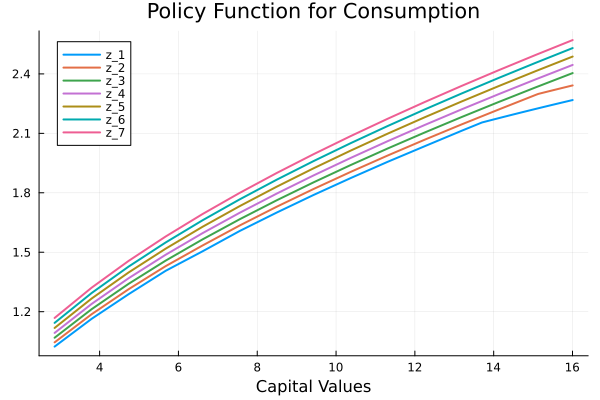

In [44]:
c_pol_new = zeros(N,nk_new);

for j=1:N 
    for i=1:nk_new
        c_pol_new[j,i] = consumption_new(a_opt_new[j,:],k_grid_new[i],k_grid_gal_new,int_new,z_grid[j],α);

        # Maximum allowed consumption (non-negative investment constraint)
        c_max = z_grid[j]*k_grid_new[i]^α;

        # Enforce the constraint
        if c_pol_new[j,i] > c_max
            c_pol_new[j,i] = c_max;
        end
    end
end

c_pol_new = c_pol_new';

plot(k_grid_new, c_pol_new, label=["z_1" "z_2" "z_3" "z_4" "z_5" "z_6" "z_7"] ,title="Policy Function for Consumption"
, xlabel="Capital Values",linewidth=2)

Get the policy function for capital:

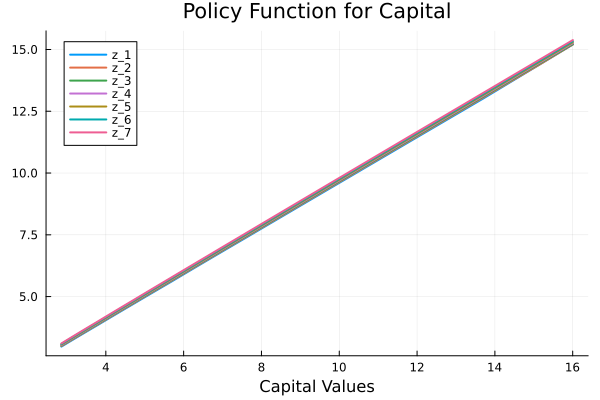

In [45]:
z_matrix_new = repeat(z_grid, 1, nk_new); # Creating a matrix by repeating grid_z to become 500x7
k_matrix_new = repeat(k_grid_new, 1, N)';  # Creating a matrix by repeating grid_k to become 7x500 and then transposing it

k_pol_new = z_matrix_new.*(k_matrix_new.^α).+(1-δ).*k_matrix_new.-c_pol_new';

k_pol_new = k_pol_new';

plot(k_grid_new, k_pol_new, label=["z_1" "z_2" "z_3" "z_4" "z_5" "z_6" "z_7"] ,title="Policy Function for Capital"
, xlabel="Capital Values",linewidth=2)

Get the policy function for investment:

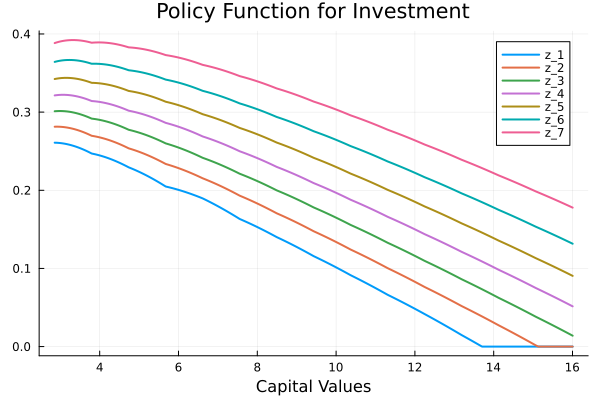

In [46]:
x_pol_new = zeros(N,nk_new);

for j=1:N
    for i=1:nk_new
        x_pol_new[j,i] = z_grid[j]*k_grid_new[i]^α - c_pol_new[i,j];
    end
end

x_pol_new = x_pol_new';

plot(k_grid_new, x_pol_new, label=["z_1" "z_2" "z_3" "z_4" "z_5" "z_6" "z_7"] ,title="Policy Function for Investment"
, xlabel="Capital Values",linewidth=2)

---
### No penalty function
Update some functions:

In [47]:
# Function to compute the consumption::: construction very similar to the explanation above
function consumption_new(a,k,grid_k,n,z,α)
   c = 0;
   for i = 1:n
        c = c + a[i]*psi(i,k,grid_k,n) 
   end
   
   # Maximum allowed consumption (non-negative investment constraint)
   c_max = z*k^α;

   # Enforce the constraint::: the intuition of the penalty function is to do the same, but in a more natural way, penalizing the agent's utility
   if c > c_max
       c = c_max;
   end
   

   return c
end

# Function to compute the residuals
function residual_new(a,k,grid_z,j,n,α,δ,N,grid_k,σ,β,T)
    c_old = consumption_new(a[j,:],k,grid_k,n,grid_z[j],α);
    g = grid_z[j]*(k^α)+(1-δ)*k - c_old; # policy function for capital
    aux1 = zeros(N,1);
    aux2 = zeros(N,1);  

    for i=1:N
        aux1[i] = 1-δ+α*grid_z[i]*g^(α-1);
        pol_c = consumption_new(a[i,:],g,grid_k,n,grid_z[i],α); # policy for c
        aux2[i] = (pol_c/c_old)^(-σ);
    end

    res = β.*T[j,:]'*(aux1.*aux2).-1; 
    # this yields a matrix 1x1. When I get the j-th row of T, Julia re-reads it as a column vector.

    res = res[1,1]; # transforming a matrix 1x1 into a float64

    return res
end

# Function to compute the system of residuals using the Gauss-Chebyshev quadrature
function system_new(int,a,grid_z,n,α,δ,N,grid_k,σ,β,T)
    residual_matrix = ones(int,N); # int is the number of quadrature points

    # Get Gauss-Chebyshev nodes over [-1,1]
    d = int-1;
    dim = d+1;
    ub_k = maximum(grid_k); #ub = upper bound
    lb_k = minimum(grid_k); #lb = lower bound

    nodes = zeros(1,dim);
    for id = 1:dim 
        nodes[id] = -cos(((2*id - 1)*π)/(2*dim));
    end

    e1 = zeros(int,N); # I should have called this e_left 
    e2 = zeros(int,N); # and this e_right
    # the sum of e1 and e2 (e_left+e_right) give me the system explained above, which has to equal zero (optimum).

    for i = 1:N 
        for j = 1:d 
            k_aux = (nodes[j]+1)*((grid_k[j+1]-grid_k[j])/2) + grid_k[j];
            aux_1 = residual_new(a,k_aux,grid_z,i,n,α,δ,N,grid_k,σ,β,T);
            aux_2 = sqrt(1-nodes[j]^2)*(grid_k[j+1]-k_aux)/(grid_k[j+1]-grid_k[j]);
            e1[j,i] = ((π*(grid_k[j+1] - grid_k[j]))/(2*d))*aux_1*aux_2; 
        end
    end

    for i= 1:N 
        for j = 2:int 
            k_aux = (nodes[j]+1)*((grid_k[j]-grid_k[j-1])/2) + grid_k[j-1];
            aux_1 = residual(a,k_aux,grid_z,i,n,α,δ,N,grid_k,σ,β,T);
            aux_2 = sqrt(1-nodes[j]^2)*(k_aux-grid_k[j-1])/(grid_k[j]-grid_k[j-1]);
            e2[j,i] = ((π*(grid_k[j] - grid_k[j-1]))/(2*d))*aux_1*aux_2;
        end
    end

    residual_matrix = e1 + e2;
    final_system = vec(residual_matrix); # stack in a vector

    return final_system

end 

system_new (generic function with 2 methods)

Define parameters and compute the optimum $a$.

In [48]:
k_ss = ( (1/α) *( (1/β) - 1 + δ) )^(1/(α-1)); # steady state capital (deterministic case)
lb_new = 0.5*k_ss; # lower bound for the grid around 30% below the SS level
ub_new = 2.8*k_ss; # lower bound for the grid around 30% above the SS level
nk_new = 700; # number of grid points
k_grid_new = LinRange(lb_new,ub_new,nk_new); # create a linearly spaced grid for capital
n_new = 15; # number of points (chosen by me)
k_grid_gal_new = LinRange(lb_new,ub_new,n_new); 
int_new = n_new; # quadrature points

root_solution_new = x -> system_new(int_new,x,z_grid,n_new,α,δ,N,k_grid_gal_new,σ,β,T);
solution_new = nlsolve(root_solution_new,a);

# Extract the roots:
a_opt_new = solution_new.zero;

Get the policy function for consumption:

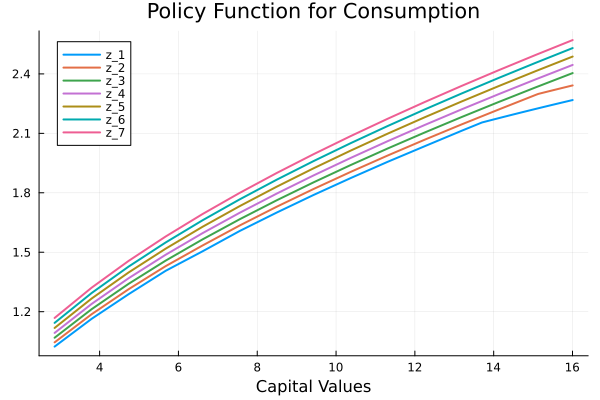

In [49]:
c_pol_new = zeros(N,nk_new);

for j=1:N 
    for i=1:nk_new
        c_pol_new[j,i] = consumption_new(a_opt_new[j,:],k_grid_new[i],k_grid_gal_new,int_new,z_grid[j],α);

        # Maximum allowed consumption (non-negative investment constraint)
        c_max = z_grid[j]*k_grid_new[i]^α;

        # Enforce the constraint
        if c_pol_new[j,i] > c_max
            c_pol_new[j,i] = c_max;
        end
    end
end

c_pol_new = c_pol_new';

plot(k_grid_new, c_pol_new, label=["z_1" "z_2" "z_3" "z_4" "z_5" "z_6" "z_7"] ,title="Policy Function for Consumption"
, xlabel="Capital Values",linewidth=2)

Get the policy function for capital:

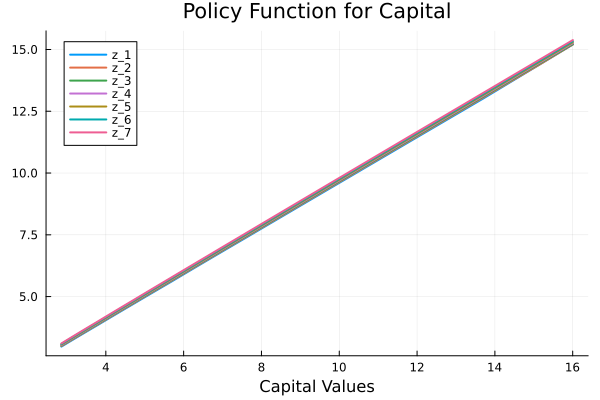

In [50]:
z_matrix_new = repeat(z_grid, 1, nk_new); # Creating a matrix by repeating grid_z to become 500x7
k_matrix_new = repeat(k_grid_new, 1, N)';  # Creating a matrix by repeating grid_k to become 7x500 and then transposing it

k_pol_new = z_matrix_new.*(k_matrix_new.^α).+(1-δ).*k_matrix_new.-c_pol_new';

k_pol_new = k_pol_new';

plot(k_grid_new, k_pol_new, label=["z_1" "z_2" "z_3" "z_4" "z_5" "z_6" "z_7"] ,title="Policy Function for Capital"
, xlabel="Capital Values",linewidth=2)

Get the policy function for investment:

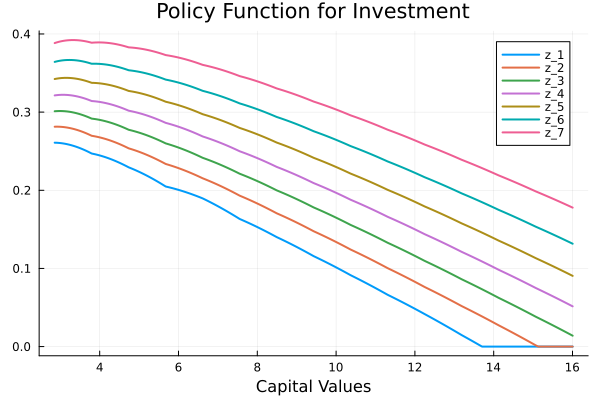

In [51]:
x_pol_new = zeros(N,nk_new);

for j=1:N
    for i=1:nk_new
        x_pol_new[j,i] = z_grid[j]*k_grid_new[i]^α - c_pol_new[i,j];
    end
end

x_pol_new = x_pol_new';

plot(k_grid_new, x_pol_new, label=["z_1" "z_2" "z_3" "z_4" "z_5" "z_6" "z_7"] ,title="Policy Function for Investment"
, xlabel="Capital Values",linewidth=2)